In [ ]:
import uproot
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hist
import re

In [ ]:
# HEPHY topside
x = np.arange(60, 86) #thr 
x = np.arange(174, 186) #HV 190-25

# HEPHY backside
x = np.arange(206, 231) #thr 
x = np.arange(234, 248) #HV 200-5
x = np.arange(251, 256) #HV 450-250
x = np.arange(271, 280) #HV 10-2

# NIKHEF backside
x = np.arange(308, 318) #HV 20-2
x = np.arange(322, 332) #HV 500-50

# Liverpool topside
x = np.arange(341, 367) #thr
x = np.arange(372, 466) #HV 500-50

# NIKHEF backside_top
x = np.arange(494, 507) #thr
x = np.arange(468, 480) #HV 190-80
x = np.arange(480, 494) #HV 70-5


In [1]:
# Define a list of ROOT files to open
root_file_list = glob.glob('/home/harald/Desktop/MPW4/desy_04_24/output/data/*.root')

# Define a list of keys (TKeys) to extract data from
#efficiency not working properly, TEfficiency sucks
keys_to_extract = [["EventLoaderEUDAQ2/RD50_MPWx_base_0/hPixelRawValues", "ToT (LSB)"],
        ["ClusteringSpatial/RD50_MPWx_base_0/clusterSize", "Cluster size"],
        ["AnalysisDUT/RD50_MPWx_base_0/local_residuals/residualsX", r"Spatial Resolution X ($\mu m$)"],
        ["AnalysisEfficiency/RD50_MPWx_base_0/fake_rate/hFakePixelPerEvent", "Fake Rate"]]

x_name = 'Bias (V)'
# x_regex = r'(\d\d)V'
output_file = '/home/harald/Desktop/MPW4/desy_04_24/output/nikhef_backside/bias_nikhef_back_characteristics_thr.svg'

run_map_file = '/home/harald/Desktop/MPW4/desy_04_24/output/nikhef_backside/scan_mapping.csv'
run_map = {}

#runs_to_analyse = np.arange(342, 367)

list1 = np.arange(308, 318)

list2 = np.arange(322, 332)

runs_to_analyse = np.concatenate((list1, list2))

root_file_list.sort()
filesToRemove = []
for r in root_file_list:
    match = re.search(r'(\d+)\.root', r)
    if match:
        runNmb = int(match.group(1))
        if not (runNmb in runs_to_analyse):
            filesToRemove.append(r)
    else:
        filesToRemove.append(r)

for f in filesToRemove:
    root_file_list.remove(f)
    
root_file_list.sort()
root_file_list

['/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_308.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_309.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_310.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_311.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_312.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_313.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_314.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_315.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_316.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_317.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_322.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_323.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/histograms_324.root',
 '/home/harald/Desktop/MPW4/desy_04_24/output/data/

In [2]:
with open(run_map_file) as f:
    for line in f:
        if line.startswith('#'):
            continue
        run, para = line.split(',')
        run = int(run)
        para = abs(float(para))
        run_map[run] = para

run_map

{308: 20.0,
 309: 18.0,
 310: 16.0,
 311: 14.0,
 312: 12.0,
 313: 10.0,
 314: 8.0,
 315: 6.0,
 316: 4.0,
 317: 2.0,
 322: 500.0,
 323: 450.0,
 324: 400.0,
 325: 350.0,
 326: 300.0,
 327: 250.0,
 328: 200.0,
 329: 150.0,
 330: 100.0,
 331: 50.0}

In [3]:
# Create an empty DataFrame to store the results
# results_df = pd.DataFrame(columns=["File", "Key", "Mean", "StdDev"])
results = {"File" : [], "Key" : [], "Name" : [], "xVal" : [], "Mean" : [], "StdDev": [], "StdErr" : [], "N" :[] }

# Loop over each ROOT file
for root_file in root_file_list:
    # Open the ROOT file using uproot
    with uproot.open(root_file) as file:
        # Loop over each key to extract data
        for key_name in keys_to_extract:
            try:
                # Access the TKey using the key name
                tkey = file[key_name[0]]
                # print(tkey)
                mean_val = 0
                std_dev_val = 0
                N = 0
                # Check if the TKey points to a TH1F histogram
                if isinstance(tkey, uproot.uproot.behaviors.TH1.TH1):                    
                    hist_np = tkey.to_numpy() # [0] ... bins, [1] ... weights
                    # hist_data = tkey.to_hist()
                    # hist_data.plot()
                    # plt.show()
                        
                    unjagged_bins = (hist_np[1][:-1] + hist_np[1][1:]) / 2
                    
                    N = np.sum(hist_np[0])
                    mean_val = np.sum(hist_np[0] * unjagged_bins) / N
                    #print('mean = ', mean_val)                    
                    std_dev_val = np.sqrt(np.sum(hist_np[0] * (unjagged_bins - mean_val)**2) / N)

                    #hacky special treatment
                    if 'hPixelRawValues' in key_name[0]:
                        mask = unjagged_bins < 100
                        N = np.sum(hist_np[0][mask])
                        mean_val = np.sum(hist_np[0][mask] * unjagged_bins[mask]) / N
                        std_dev_val = np.sqrt(np.sum(hist_np[0][mask] * (unjagged_bins[mask] - mean_val)**2) / N)
                    #print('std', std_dev_val)
                elif isinstance(tkey, uproot.uproot.behaviors.TProfile2D.TProfile2D):
                    # print('encountered a', tkey)
                    vals = tkey.values()
                    # print(vals, np.average(vals))
                    mean_val = np.average(vals)
                    std_dev_val = np.std(vals)
                    N = 1
                else:
                    continue

                runNmb = int(re.search(r'(\d+)\.root', root_file).group(1))
                results["xVal"].append(run_map[runNmb])
                results["Mean"].append(mean_val)
                results['StdDev'].append(std_dev_val)
                results['File'].append(root_file)
                results['Key'].append(key_name[0])
                results['Name'].append(key_name[1])
                results["N"].append(N)
                results["StdErr"].append(std_dev_val / np.sqrt(N))

            except KeyError:
                print(f"Key '{key_name}' not found in file '{root_file}'")

df = pd.DataFrame(results)
df

,File,Key,Name,xVal,Mean,StdDev,StdErr,N
0,/home/harald/Desktop/MPW4/desy_04_24/output/da...,EventLoaderEUDAQ2/RD50_MPWx_base_0/hPixelRawVa...,ToT (LSB),20.0,4.471479,1.923659,0.002289,706019.0
1,/home/harald/Desktop/MPW4/desy_04_24/output/da...,ClusteringSpatial/RD50_MPWx_base_0/clusterSize,Cluster size,20.0,1.067340,0.359062,0.000441,661524.0
2,/home/harald/Desktop/MPW4/desy_04_24/output/da...,AnalysisDUT/RD50_MPWx_base_0/local_residuals/r...,Spatial Resolution X ($\mu m$),20.0,-8.343563,19.563849,0.029059,453265.0
3,/home/harald/Desktop/MPW4/desy_04_24/output/da...,AnalysisEfficiency/RD50_MPWx_base_0/fake_rate/...,Fake Rate,20.0,0.832526,0.679601,0.000738,848107.0
4,/home/harald/Desktop/MPW4/desy_04_24/output/da...,EventLoaderEUDAQ2/RD50_MPWx_base_0/hPixelRawVa...,ToT (LSB),18.0,4.349074,1.895959,0.002285,688581.0
...,...,...,...,...,...,...,...,...
75,/home/harald/Desktop/MPW4/desy_04_24/output/da...,AnalysisEfficiency/RD50_MPWx_base_0/fake_rate/...,Fake Rate,100.0,0.998453,0.918823,0.000997,849970.0
76,/home/harald/Desktop/MPW4/desy_04_24/output/da...,EventLoaderEUDAQ2/RD50_MPWx_base_0/hPixelRawVa...,ToT (LSB),50.0,5.768815,2.341746,0.002645,784042.0
77,/home/harald/Desktop/MPW4/desy_04_24/output/da...,ClusteringSpatial/RD50_MPWx_base_0/clusterSize,Cluster size,50.0,1.137330,0.515867,0.000621,689422.0
78,/home/harald/Desktop/MPW4/desy_04_24/output/da...,AnalysisDUT/RD50_MPWx_base_0/local_residuals/r...,Spatial Resolution X ($\mu m$),50.0,0.530705,19.856429,0.028840,474052.0


In [4]:
def annotate_points(df, col_name):
    for index, row in df.iterrows():
        if col_name != row['Key']:
            continue
        x = row['xVal']
        y = row['Mean']
        val = f'{row["Mean"]:.2f}'

        # hacky special treatment
        if 'residuals' in col_name:
            y = row['StdDev']
            val = f'{row["StdDev"]:.2f}'
        plt.annotate(val, (x, y), textcoords="offset points", xytext=(10, 15), ha='center', fontsize=8)

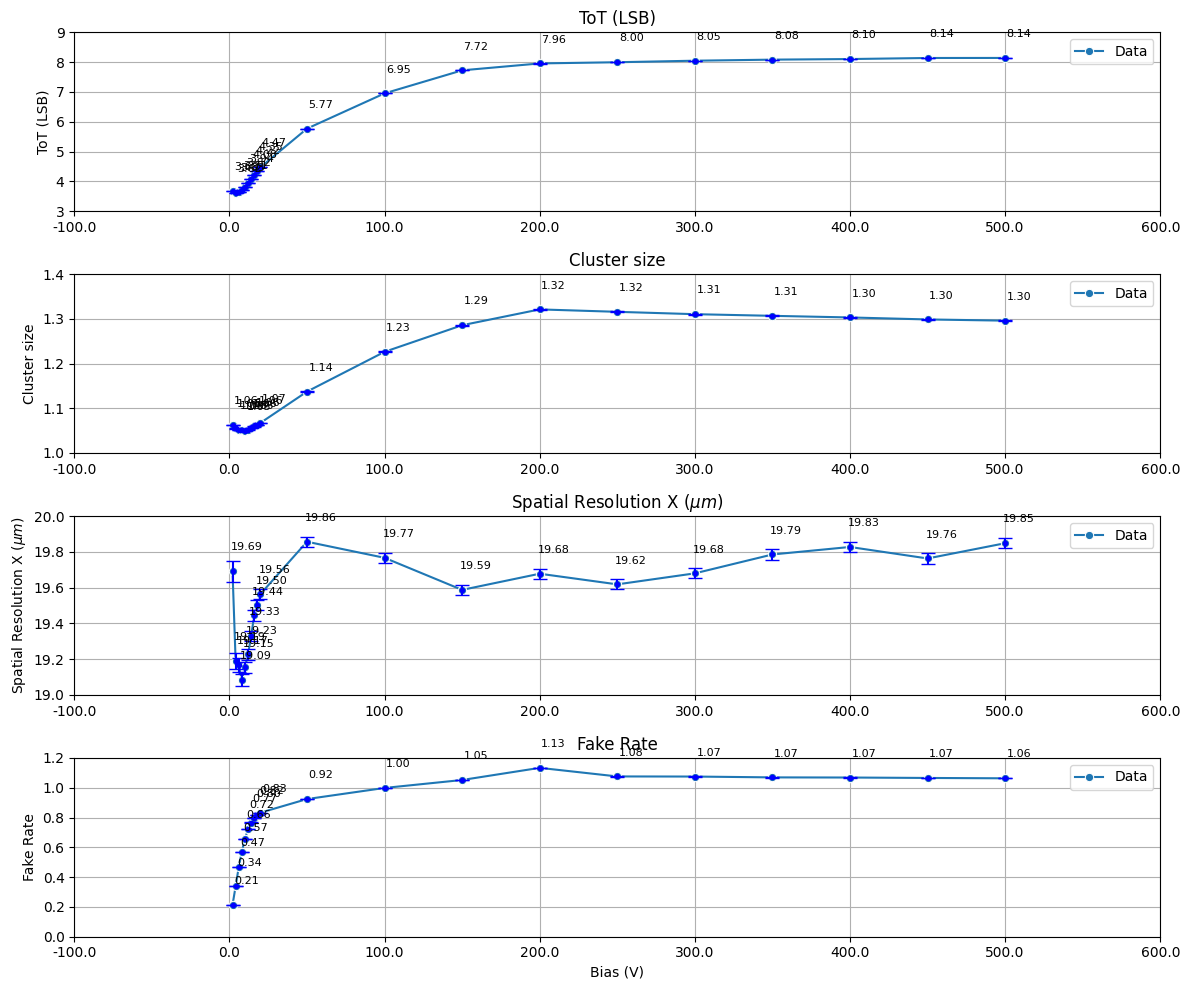

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your existing code for creating subplots
plt.figure(figsize=(12, 10))

for i, key in enumerate(keys_to_extract):
    keyrows = df[df['Key'].str.contains(key[0])]  # Get sub dataframe where all rows containing the current key are in
    plt.subplot(4, 1, i + 1)
    
    x = keyrows['xVal']
    y = keyrows['Mean']
    # hacky special treatment
    if 'residuals' in key[0]:
        y = keyrows['StdDev']
    
    yerr = df[df['Key'].str.contains(key[0])]['StdErr'].values
    
    # Plot a line plot with error bars
    sns.lineplot(x=x, y=y, label='Data', marker='o')
    plt.errorbar(x, y, yerr=yerr, fmt='.', color='blue', capsize=5)  # Add error bars
    
    plt.xlabel('')
    plt.ylabel(key[1])
    plt.title(key[1])
    annotate_points(df, key[0])

    # Add grid lines for both x-axis and y-axis in all subplots
    plt.grid(True, which='both')

    # Set y-ticks for all subplots
    plt.gca().set_yticks(plt.gca().get_yticks())

    ax = plt.gca()  # Get the current axis (last subplot)
    ax.set_xticks(ax.get_xticks())  # This line refreshes the tick locations
    ax.set_xticklabels(ax.get_xticks())  # Set tick labels to be the same as tick locations

plt.xlabel(x_name)
# Adjust layout
plt.tight_layout()

plt.savefig(output_file)
plt.show()
